In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:30<00:00,  1.69it/s]


In [3]:
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset_without_big = ThicknessDataset(PATH, mode=1, transform=augs)
thickness_dataset_only_big = ThicknessDataset(PATH, mode=2, transform=augs)
print("Number of samples in dataset without large object", len(thickness_dataset_without_big))
print("Number of samples in dataset with only large objects", len(thickness_dataset_only_big))

train_split = 0.9
valid_split = 0.1
train_size = int(train_split * len(thickness_dataset_without_big))+1
valid_size = int(valid_split * len(thickness_dataset_without_big))


train_dataset, valid_dataset = torch.utils.data.random_split(thickness_dataset_without_big, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

test_dataset = thickness_dataset_only_big

print("Number of batches in train dataset", len(train_dataset))
print("Number of batches in valid dataset", len(valid_dataset))
print("Number of batches in test dataset", len(test_dataset))

batch_size = 16 # 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=128)

Number of samples in dataset without large object 5514
Number of samples in dataset with only large objects 1038
Number of batches in train dataset 4963
Number of batches in valid dataset 551
Number of batches in test dataset 1038


In [4]:
path = "models\Partial Train\model_20230303-183712_105"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = U_Net()

criterion = nn.MSELoss()
model = model.to(device)
model.load_state_dict(torch.load(path))
model.eval()
trained_model = model

Using cuda device


In [5]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans, mse_loss_with_nans_with_extras
mse_full_loss = 0
mmse_full_loss = 0
mmse_full_loss_extr = 0

batches = 0
catagory_losses = {}
catagory_index = {} # appends tuple to list that stores as batch_no, idx in batch

loss_fn = torch.nn.MSELoss()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        catagory_id = data['catagory_id']
        outputs = trained_model(images)

        mse_loss = loss_fn(outputs, labels)
        masked_lossv0 = mse_loss_with_nans(outputs, labels)
        masked_lossv1, losses = mse_loss_with_nans_with_extras(outputs, labels)
        # using the catagory id to keep adding the loss to the scores
        for i in range(losses.shape[0]):
            if catagory_id[i] in catagory_losses:
                catagory_losses[catagory_id[i]].append(losses[i].cpu().numpy())
                catagory_index[catagory_id[i]].append((batches, i))
                
            else:
                catagory_losses[catagory_id[i]] = [losses[i].cpu().numpy()]
                catagory_index[catagory_id[i]] = [(batches, i)]

        mse_full_loss += mse_loss.item()
        mmse_full_loss += masked_lossv0
        mmse_full_loss_extr += masked_lossv1
        batches += 1
print("Test MSE loss: {}".format(mse_full_loss/batches))
print("Test MMSE loss: {}".format(mmse_full_loss/batches))
print("Test MMSE loss with extras: {}".format(mmse_full_loss_extr/batches))

Test MSE loss: 0.00046981821813258447
Test MMSE loss: 0.005435173399746418
Test MMSE loss with extras: 0.005435173399746418


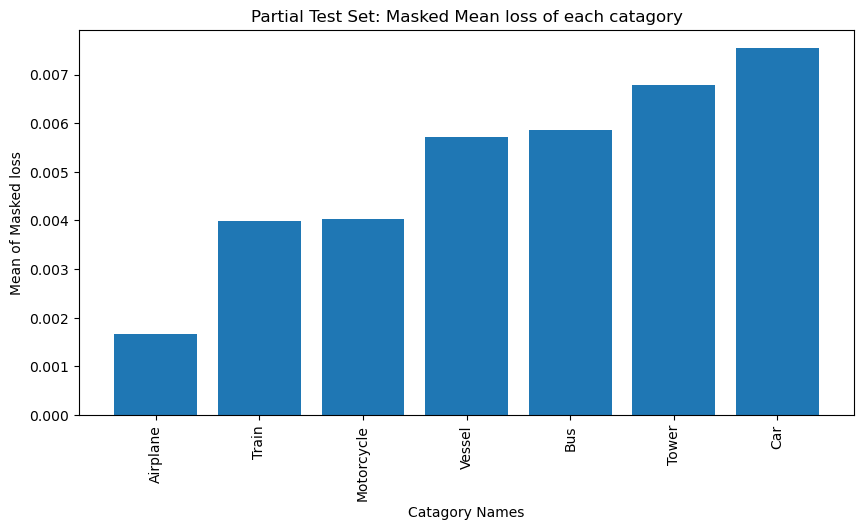

In [6]:
# for each catagory calculate the mean then plot a bar graph of the mean loss of each catagory
catagory_mean_losses = {}
for catagory in catagory_losses:
    catagory_mean_losses[catagory] = np.mean(catagory_losses[catagory])
catagory_lens = {}
for catagory in catagory_losses:
    catagory_lens[catagory] = len(catagory_losses[catagory])


catagory_mean_losses = {k: v for k, v in sorted(catagory_mean_losses.items(), key=lambda item: item[1])}
# normalise the mean losses
# catagory_mean_losses = {k: v- (full_loss/batches).cpu() for k, v in catagory_mean_losses.items()}

fig = plt.figure(figsize=(10, 5))
plt.title("Partial Test Set: Masked Mean loss of each catagory")
plt.xlabel("Catagory Names")
plt.ylabel("Mean of Masked loss")
    # change the xticks rotate the labels 90 degrees
plt.bar(catagory_mean_losses.keys(), catagory_mean_losses.values())
plt.xticks(rotation=90)
# using thickness_dataset.labels to get the catagory name strings for the xticks
plt.xticks(list(catagory_mean_losses.keys()), [thickness_dataset.labels[i].split(',')[0].capitalize() for i in catagory_mean_losses.keys()])


plt.show()
# save as pdf
fig.savefig("figs\\partial\\mean_loss_of_each_catagory.pdf", bbox_inches='tight')


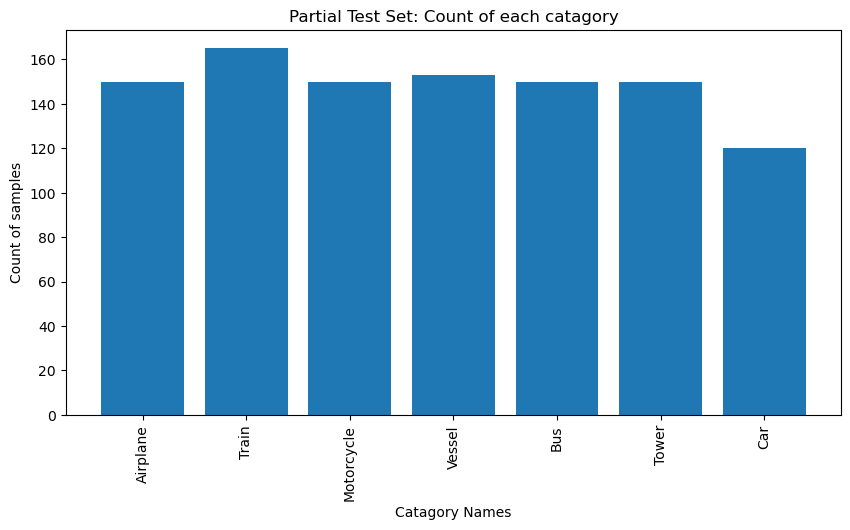

In [7]:
# plot count of each catgory, sorted by the acending mean loss dict
# catagory_lens sorted by the mean loss dictionary catagory_mean_losses

catagory_lens = {k: v for k, v in sorted(catagory_lens.items(), key=lambda item: catagory_mean_losses[item[0]])}

fig = plt.figure(figsize=(10, 5))
plt.title("Partial Test Set: Count of each catagory")
plt.xlabel("Catagory Names")
plt.ylabel("Count of samples")

plt.bar(catagory_lens.keys(), catagory_lens.values())
plt.xticks(rotation=90)
# using thickness_dataset.labels to get the catagory name strings for the xticks
plt.xticks(list(catagory_lens.keys()), [thickness_dataset.labels[i].split(',')[0].capitalize() for i in catagory_lens.keys()])
plt.show()
# save as pdf
fig.savefig("figs\\partial\\count_of_each_catagory.pdf", bbox_inches='tight')


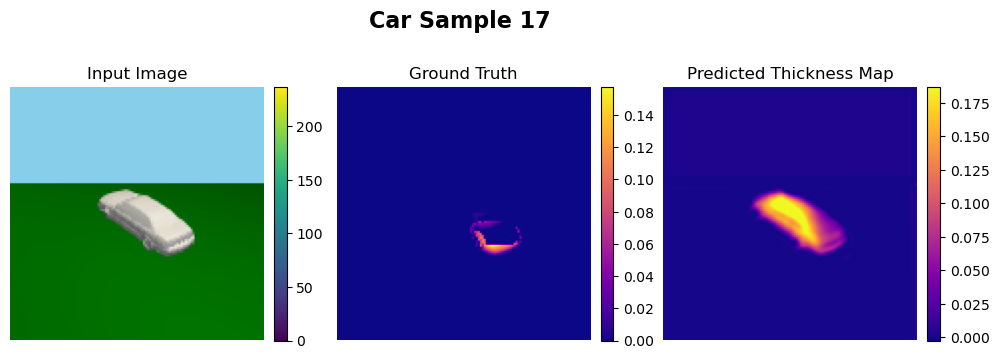

Structure Simililarity:  0.9377058196677212
Masked Loss:  tensor(0.0092)


In [8]:
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
id = "02958343"
num = 17
# locator 
batch_no, sample_no =catagory_index[id][num]
iters = 0
with torch.no_grad():
    for data in test_dataloader:
        samples = data
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        image_locs = data['img_loc']
        outputs = trained_model(images)
        masked_loss, losses = mse_loss_with_nans_with_extras(outputs, labels)
        if iters == batch_no:
            for i in range(outputs.shape[0]):
                if i == sample_no:
                    img_loc = image_locs[i]

                    fig = plt.figure(figsize=(12,8))
                    grid = ImageGrid(fig, 111,
                                     nrows_ncols = (1,3),
                                     axes_pad = .5,
                                     cbar_location = "right",
                                     cbar_mode="each",
                                     cbar_size="5%",
                                     cbar_pad=0.1,
                                    )

                    im1 = grid[0].imshow(cv2.cvtColor(cv2.imread(img_loc), cv2.COLOR_BGR2RGB), aspect="equal")
                    grid[0].set_title('Input Image')
                    grid[0].axis('off')
                    grid.cbar_axes[0].colorbar(im1)
                    grid.cbar_axes[0].toggle_label(True)
                    im2 = grid[1].imshow(labels[i].cpu().numpy()[0], cmap='plasma')
                    grid[1].set_title('Ground Truth')
                    grid[1].axis('off')
                    grid.cbar_axes[1].colorbar(im2)

                    im3= grid[2].imshow(outputs[i].cpu().numpy()[0], cmap='plasma',vmax = 0.187)
                    grid[2].set_title('Predicted Thickness Map')
                    grid[2].axis('off')
                    # colorbar of im3 is the same scale as im2 
                    

                    grid.cbar_axes[2].colorbar(im3)



                    fig.suptitle(f"{thickness_dataset.labels[id].split(',')[0].capitalize()} Sample {num}", fontsize=16,y=0.75, fontweight = "600")
                    plt.show()
                    fig.savefig("figs\\partial\\samples\\sample_{}_from_catagory_{}.pdf".format(num, data['catagory_id'][i]), bbox_inches='tight')
                    print("Structure Simililarity: ",ssim(labels[i].cpu().numpy()[0], outputs[i].cpu().numpy()[0].reshape(128,128)))
                    print("Masked Loss: ", losses[i])
                    break
            break
        iters +=1